## Modules

In [12]:
import os
from tqdm import tqdm

import numpy as np
from scipy.signal import find_peaks, correlate
from scipy.ndimage import gaussian_filter, median_filter
from scipy.stats import sem
from signal_analysis import SignalAnalysis

import seaborn as sns
import seaborn_image as isns
import cmcrameri.cm as cmc
from matplotlib import pyplot as plt


cmap = 'cmc.batlow'
sns.set_palette(cmap)

## Analysis Functions

In [8]:
def absorptionCoefficientVariation(intensity:list, wavelength:int=530, dim:int=3) -> list:
    """Calculates the absorption coefficient variation for a specific wavelength

    Args:
        intensity (list): light signal over time
        wavelength (int, optional): wavelength of light, either 530 or 625 nm. Defaults to 530.
        dim (int, optional): dimension of data. Defaults to 3.

    Returns:
        list: variation of mu_a coefficient over time
    """
    if wavelength == 530:
        X = 0.371713            # mm
    elif wavelength == 625:
        X = 3.647821            # mm
    else:
        print('Wrong wavelength input: 530 or 630 only')
        return None
    
    if dim == 3:
        iniIntens = intensity[:,:,0][..., np.newaxis]
        iniIntens[np.where(iniIntens == 0)] = 1
        mu = (-1/X)* np.log(intensity/iniIntens)

    elif dim == 2:
        iniIntens = intensity[:,0][..., np.newaxis]
        iniIntens[np.where(iniIntens == 0)] = 1
        mu = (-1/X)* np.log(intensity/iniIntens)

    elif dim == 1:
        iniIntens = intensity[0][..., np.newaxis]
        iniIntens[np.where(iniIntens == 0)] = 1
        mu = (-1/X)* np.log(intensity/iniIntens)

    # np.where(iniIntens == 0, 1, iniIntens)
    # print(np.shape(iniIntens))
    # with open('iniIntens{}.txt'.format(wavelength), 'w') as outfile:
    #     for dataslice in iniIntens:
    #         np.savetxt(outfile, dataslice)
    return mu


def oxygenation(greenData: list, redData: list, dim:int=3) -> tuple:
    """Generates a tuple that contains the variation of HbO and HbR concentrations over time

    Args:
        greenData (list): 530 nm absorption coefficient evolution in time
        redData (list): 625 nm absorption coefficient evolution in time
        dim (int, optional): _description_. Defaults to 3.

    Returns:
        tuple: variation of HbR and HbO over time (delta c_HbR, delta c_HbO)
    """

    mu_530 = absorptionCoefficientVariation(greenData, 530, dim)
    mu_625 = absorptionCoefficientVariation(redData, 625, dim)

    eHbO_530 = 39956.8
    eHbR_530 = 39036.4
    eHbO_625 = 740.8
    eHbR_625 = 5763.4

    dc_HbR = (eHbO_530*mu_625 - eHbO_625*mu_530)/(eHbO_530*eHbR_625 + eHbO_625*eHbR_530)
    dc_HbO = (eHbR_530*mu_625 - eHbR_625*mu_530)/(eHbR_530*eHbO_625 + eHbR_625*eHbO_530)

    return (dc_HbR, dc_HbO)

## Open data

In [20]:
pathBase = r"C:\Users\gabri\Desktop\testAnalyse\2024_07_18"

green = np.loadtxt(pathBase + "\\csv\\530.csv", skiprows=1, delimiter=',')
green = green[:,1]
red = np.loadtxt(pathBase + "\\csv\\625.csv", skiprows=1, delimiter=',')
red = red[:,1]


# green_t = np.load(pathBase + "\\530ts.npy")
# red_t = np.load(pathBase + "\\625ts.npy")

## AP time series

In [41]:
ts = np.array(list(range(len(red))))/10
print(ts[-1])

FPS = 50
AP_idx = []
nChannels=5
AP_begin = 5
percycle=15
FPSc = FPS/nChannels
framespcycles = int(FPSc*percycle)
ncycles = int(len(ts)//framespcycles)
AP_times = np.array(list(range(ncycles)))*15+5

for ti in AP_times:
    AP_idx.append(np.argmin(np.absolute(ts-ti)))

# Dirac où AP dans times series
AP_series = np.zeros(len(ts))
AP_series[AP_idx] = 1

259.2


## Tests

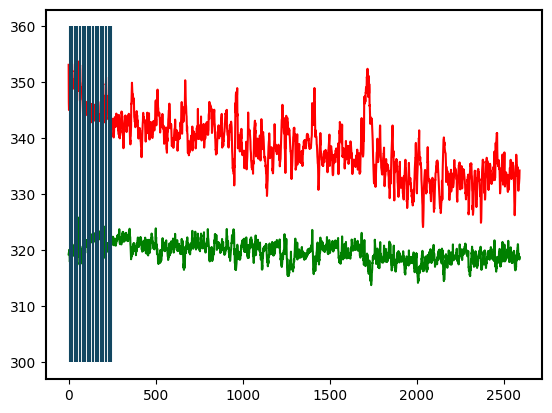

In [42]:
plt.plot(green, 'g-')
plt.plot(red-600, 'r-')

plt.vlines(ts[AP_idx], 300, 360)
# plt.xlim(0, 100)